# Training with PyTorch

This notebook is referenced from the sixth video in the [PyTorch Beginner Series](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN) by Brad Heintz on YouTube. The video focuses on the basic concepts in PyTorch that are used to handle several deep learning tasks and demonstrates how these concepts come together to make PyTorch a robust machine learning framework. You can find the notebook associated with the video [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html).


In [1]:
# Import libraries here
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import DataLoader

from scripts import plot_utils

## Get the Dataset

The following tasks are to be performed:

- Download the Fashion MNIST dataset.
- Setup the data transformers.
- Setup the data loaders.


In [2]:
# Setup the data transformer
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Get training and validation datasets
train_set = torchvision.datasets.FashionMNIST(
    '../data', train=True, transform=transform, download=True,
)
valid_set = torchvision.datasets.FashionMNIST(
    '../data', train=False, transform=transform, download=True,
)

print(f'Training set has {len(train_set)} instances.')
print(f'Validation set has {len(valid_set)} instances.')

Training set has 60000 instances.
Validation set has 10000 instances.


In [3]:
# Get the training classes
classes = train_set.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
# Create the data loaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True)

train_loader, valid_loader

(<torch.utils.data.dataloader.DataLoader at 0x30bc3ceb0>,
 <torch.utils.data.dataloader.DataLoader at 0x30bc3d120>)

## Visualize the Data

This step involves exploring the data by visualizing the images with their classifications.


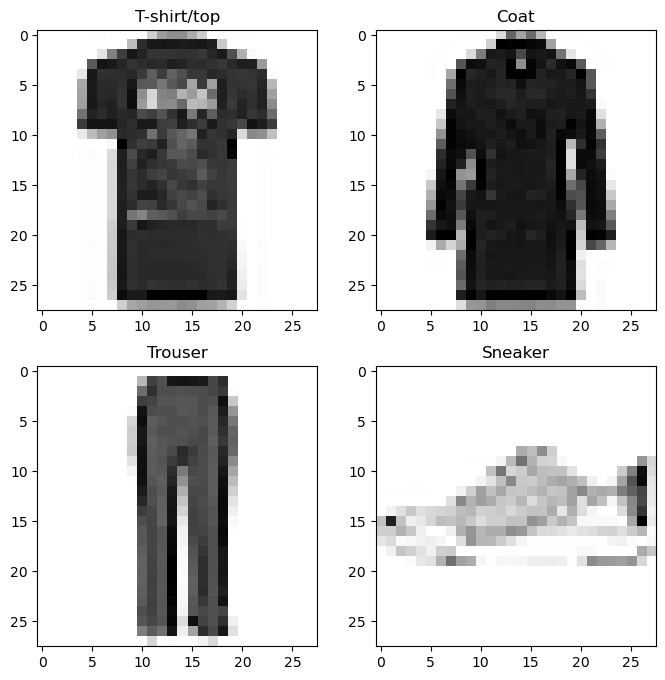

In [5]:
# Plot some images from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(8, 8))
for idx, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(2, 2, idx + 1)
    plot_utils.plot_image(image, is_norm=True,
                          label=classes[label],
                          mean=(0.5,), std=(0.5,),
                          is_one_channel=True)
plt.show()

## Build the Model

The tasks that are needed to be performed in this step are as follows:

- Setup the model architecture.
- Setup the loss function.
- Setup the optimizer.
- Create a training loop.
- Evaluate the performance.
- Save the model.


In [6]:
class FashionClassifier(nn.Module):
    """Multi-class classifer for the Fashion MNIST dataset."""

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [7]:
# Initialize the model
fashion_clf = FashionClassifier()
print(f'The Model Architecture:\n{fashion_clf}')

# Select a loss function
loss_fn = nn.CrossEntropyLoss()
print(f'\nLoss Function: {loss_fn}')

# Select an optimizer
optimizer = optim.Adam(fashion_clf.parameters(), lr=0.001)
print(f'\nOptimizer: {optimizer}')

The Model Architecture:
FashionClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Loss Function: CrossEntropyLoss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [8]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer
) -> tuple[Tensor, Tensor]:
    running_loss = 0.   # stores the loss of the current non-reported batch
    last_loss = 0.      # stores the average loss of the last reported batch

    # Track predictions for evaluation
    eval_data = dict(targets=[], preds=[])

    for i, data in enumerate(train_loader):
        # Extract inputs and labels from the data
        inputs, labels = data

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Make predictions on the batch data
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Add evaluation data
        eval_data['targets'].extend(labels)
        eval_data['preds'].extend(outputs.argmax(dim=1))

        # Report the loss
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print(f'    Batch {i + 1:5d} - Loss: {last_loss:.5f}')
            running_loss = 0.

    # Compute training accuracy
    accuracy = accuracy_score(y_true=eval_data['targets'],
                              y_pred=eval_data['preds'])

    return last_loss, accuracy

In [9]:
# Setup constants
N_EPOCHS = 5

# Track the best validation loss
best_vloss = 1_000_000.

# Track the best model state
best_model = fashion_clf.state_dict()

# Train for N_EPOCHS epochs
for epoch in range(N_EPOCHS):
    print(f'EPOCH {epoch + 1}:')

    # Ensure that gradient tracking is on
    fashion_clf.train()

    # Pass over the data once and train the model
    avg_loss, accuracy = train_model(
        model=fashion_clf,
        train_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )

    # Track the current validation loss
    running_vloss = 0.

    # Set the model to evaluation mode, disabling dropout
    # and population statistics for batch normalization
    fashion_clf.eval()

    # Track evaluation data for computing validation accuracy
    veval_data = dict(targets=[], preds=[])

    # Disable gradient computation and compute validation statistics
    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = fashion_clf(vinputs)

            # Compute the validation loss
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            # Add the evaluation data
            veval_data['targets'].extend(vlabels)
            veval_data['preds'].extend(voutputs.argmax(dim=1))

        # Compute the average validation loss and validation accuracy
        avg_vloss = running_vloss / (i + 1)
        vaccuracy = accuracy_score(y_true=veval_data['targets'],
                                   y_pred=veval_data['preds'])
        print(f'loss     : {avg_loss:.5f}, val_loss     : {avg_vloss:.5f}')
        print(f'accuracy : {accuracy:.5f}, val_accuracy : {vaccuracy:5f}\n')

    # Track best performance and best model state
    if avg_loss < best_vloss:
        best_vloss = avg_loss
        best_model = fashion_clf.state_dict()

EPOCH 1:
    Batch  1000 - Loss: 1.95284
    Batch  2000 - Loss: 1.86563
    Batch  3000 - Loss: 1.81629
    Batch  4000 - Loss: 1.79252
    Batch  5000 - Loss: 1.78422
    Batch  6000 - Loss: 1.77708
    Batch  7000 - Loss: 1.77478
    Batch  8000 - Loss: 1.76244
    Batch  9000 - Loss: 1.76018
    Batch 10000 - Loss: 1.75466
    Batch 11000 - Loss: 1.77003
    Batch 12000 - Loss: 1.72658
    Batch 13000 - Loss: 1.66014
    Batch 14000 - Loss: 1.65208
    Batch 15000 - Loss: 1.65525
loss     : 1.65525, val_loss     : 1.68707
accuracy : 0.69285, val_accuracy : 0.773300

EPOCH 2:
    Batch  1000 - Loss: 1.65126
    Batch  2000 - Loss: 1.65303
    Batch  3000 - Loss: 1.65250
    Batch  4000 - Loss: 1.63814
    Batch  5000 - Loss: 1.65739
    Batch  6000 - Loss: 1.69947
    Batch  7000 - Loss: 1.65402
    Batch  8000 - Loss: 1.64366
    Batch  9000 - Loss: 1.65974
    Batch 10000 - Loss: 1.64279
    Batch 11000 - Loss: 1.62101
    Batch 12000 - Loss: 1.64253
    Batch 13000 - Loss: 1.6378

In [10]:
# Print the best validation loss
print(f'Best validation loss: {best_vloss:.5f}')

Best validation loss: 1.63551


In [11]:
# Save the best model for future use
torch.save(best_model, '../models/06_fashion_clf.pt')